### Aplicando método de otimização para ajuste do modelo
### Argentina - Dados de Óbitos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# sigmoid.py (https://github.com/fpelogia/epid-models/blob/master/sigmoid.py)
from sigmoid import f_t, deriv_f_t 
# new_wave.py (https://github.com/fpelogia/epid-models/blob/master/new_wave.py)
from new_wave import new_wave_detection, filter_data, forward_euler 

In [2]:
#import data
data = pd.read_csv("Datasets/rosario_obitos.csv") 
city_name = 'Rosario' 
acc_data = data.cumulative_deceased
normalized_acc_data = acc_data / max(acc_data)
t = np.linspace(1, len(acc_data), len(acc_data))

# for the "one wave" tests
model = f_t
n_days = 300 

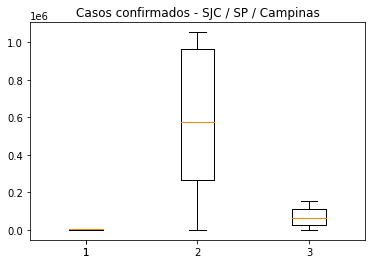

In [3]:
plt.title('Casos confirmados - SJC / SP / Campinas')
plt.boxplot(acc_data)
data = pd.read_csv("Datasets/sp.csv")  
sp = data.total_confirmed
data = pd.read_csv("Datasets/campinas.csv")  
camp = data.total_confirmed
plt.boxplot([acc_data, sp, camp])
plt.show()

### 1 - Uma onda epidemiológica

#### 1.1 - Definindo o problema de otimização
Definiremos uma função para descrever a perda do modelo em relação aos dados reais. Ela será a função objetivo do problema de minimização.

Seja o vetor x de parâmetros:
$$x = [A\quad \nu\quad \delta\quad t_p]^T$$
Problema de otimização descrito no artigo da ASOC:
$$min \sum_{t=0}^{t=t_{end}} t(y_t(t) - y_m(t, x))^2$$ 

$$\textrm{s.t.}\quad A \geq 0,\\\quad\quad\ \nu > 0,\\\quad\quad\ \delta > 0,\\\quad\quad\  t_p \geq 0$$ 

Ao invés de utilizarmos a função objetivo apresentada (ITSE), _utilizaremos a Mean Squared Error_ (MSE), que pode ser formulada da seguinte forma:
$$MSE(x) = \sum_{t=0}^{t=t_{end}} (y_t(t) - y_m(t, x))^2$$

A otimização será feita em duas etapas:
- 1 - Otimizar uma sigmoide simétrica ($\nu$ = 1)
- 2 - Otimizar uma sigmoide assimétrica, utilizando o ponto ótimo da etapa 1 como ponto inicial.

Para a implementação, estamos utilizando a função [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
) do pacote do otimização da biblioteca Scipy. O método de otimização utilizado é o _Sequential Least Squares Programming_ (SLSQP).

![](https://i.imgur.com/4goNTaQ.png)

A função em questão também permite a utilização de diversos outros métodos de otimização.

![](https://i.imgur.com/m2hO3lL.png)



In [4]:
n_sig = 1
sig_params = []
def model(t, A, tp, delta, nu):
    res = np.zeros(n_days)
    for i in range(n_sig - 1):
        [A_i, tp_i, delta_i, nu_i] = sig_params[i]
        res += f_t(t[:n_days], A_i, tp_i, delta_i, nu_i)

    res += f_t(t[:n_days], A, tp, delta, nu)
    return res

# Integral Time Square Error (ITSE)
def ITSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_data[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return np.sum(t[:n_days]*(y_t - y_m)**2)

# Mean Squared Error (MSE)
def MSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_data[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return (1/len(y_t))*np.sum((y_t - y_m)**2)

def loss_f(x, lf):
    if(lf == 'MSE'):
        return MSE(x)
    elif(lf == 'ITSE'):
        return ITSE(x)
    else:
        return MSE(x)


def loss_f_sym(x, lf):
    # nu = 1 (symmetric sigmoid)
    if(lf == 'MSE'):
        return MSE([x[0], x[1], x[2], 1]) 
    elif(lf == 'ITSE'):
        return ITSE([x[0], x[1], x[2], 1]) 
    else:
        return MSE([x[0], x[1], x[2], 1]) 
    

# Inequality contraints need to return f(x), where f(x) >= 0
def constr1(x):
    # A >= 0
    return x[0]
def constr2(x):
    # tp >= 0
    return x[1]
def constr3(x):
    # delta >= 0.1
    return x[2] - 1e-1
def constr4(x):
    # nu > 0.1
    return x[3] - 1e-1

con1 = {'type':'ineq', 'fun':constr1}
con2 = {'type':'ineq', 'fun':constr2}
con3 = {'type':'ineq', 'fun':constr3}
con4 = {'type':'ineq', 'fun':constr4}     
cons = [con1, con2, con3, con4] 

/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 469.0093990064103
     jac: array([-4.57763672e-05, -2.28500366e-03, -9.91821289e-05,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 159
     nit: 28
    njev: 27
  status: 0
 success: True
       x: array([2.06172059e+03, 2.25945418e+02, 1.59233969e+01, 1.00000000e+00])


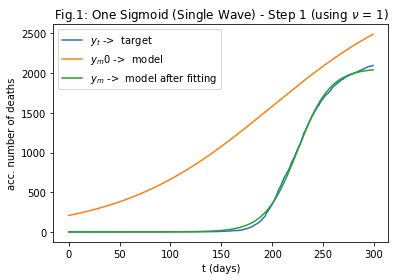

In [5]:
# Step 1 - Optimize a symmetric sigmoid (nu = 1)
y_t = acc_data[:n_days]
A0 = 1.5*max(y_t)
tp0 = (2/3)*len(y_t)
delta0 = (1/4)*len(y_t)
nu0 = 1
x0 = [A0, tp0, delta0, nu0]
sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
print(sol)

# Optimal values
[A, tp, delta, nu] = sol.x

y_m0 = f_t(t[:n_days], A0, tp0, delta0, nu0)
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('Fig.1: One Sigmoid (Single Wave) - Step 1 (using $\\nu$ = 1)')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m0, label='$y_m0$ ->  model')
plt.plot(y_m, label='$y_m$ ->  model after fitting')
plt.xlabel('t (days)')
plt.ylabel('acc. number of deaths')
plt.legend()
plt.show()

     fun: 46.95479931477193
     jac: array([ 8.53538513e-05, -1.79290771e-04, -2.82001495e-03, -9.39798355e-03])
 message: 'Optimization terminated successfully'
    nfev: 86
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([2.15119594e+03, 2.20032485e+02, 2.29290696e+01, 2.50076830e-01])


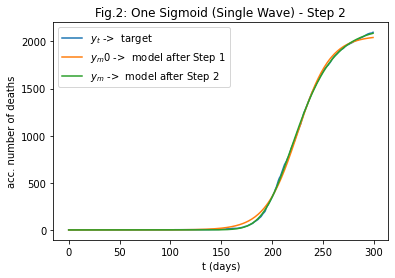

In [6]:
# Step 2 - Optimize an assymmetric sigmoid
# using optimal values of step 1 as the starting point
[A0, tp0, delta0, nu0] = sol.x

x0 = [A0, tp0, delta0, nu0]
sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
print(sol)

# Optimal values
[A, tp, delta, nu] = sol.x

y_t = acc_data[:n_days]
y_m0 = f_t(t[:n_days], A0, tp0, delta0, nu0)
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('Fig.2: One Sigmoid (Single Wave) - Step 2')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m0, label='$y_m0$ ->  model after Step 1')
plt.plot(y_m, label='$y_m$ ->  model after Step 2')
plt.xlabel('t (days)')
plt.ylabel('acc. number of deaths')
plt.legend()
plt.show()

### 2 - Múltiplas ondas epidemiológicas
Para fazer o ajuste do modelo para dados de N ondas epidemiológicas, utilizamos um modelo que envolve a soma de N sigmoides ($f(t)$).

![](https://i.imgur.com/YixfYwH.png)

[Escrever aqui um textinho mais elaborado documentando a lógica para múltiplas ondas]

In [7]:
a = []
a.append([1, 2, 3, 4])
a.append([5, 6, 7, 8])
print(a)
print(a[0])

[[1, 2, 3, 4], [5, 6, 7, 8]]
[1, 2, 3, 4]


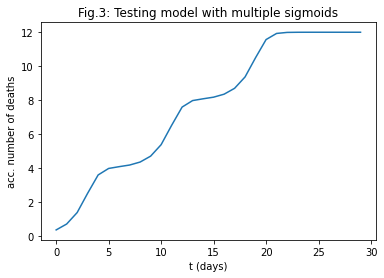

In [8]:
# Testing model for multiple sigmoids
n_days = 30
n_sig = 3
sig_params = [
    [4, 4, 0.5, 2.9],
    [4, 12, 0.5, 2.9]
]
[A, tp, delta, nu] = [4, 20, 0.5, 2.9]
plt.title('Fig.3: Testing model with multiple sigmoids')
plt.plot(model(t[:n_days], A, tp, delta, nu))
plt.xlabel('t (days)')
plt.ylabel('acc. number of deaths')
plt.show()

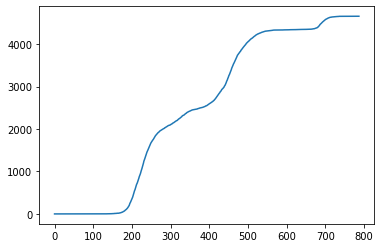

In [9]:
plt.plot(acc_data)

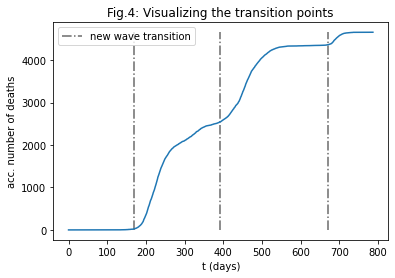

In [10]:
fig = plt.figure()
plt.plot(acc_data)
# Defini manualmente, por enquanto...
# pelo new_wave.py daria x_t [11, 101, 167, 254] (Jerusalem)
#x_nw = [90, 170, 240] #(Jerusalém)
#x_nw = [147, 287, 382, 669] #(SJC)
#x_nw = [84, 259, 314, 375, 688] # (SP)
#x_nw  = [94, 146, 269, 314, 377, 469, 607, 677, 741] # Campinas tr 2e-5
#x_nw = [8, 166, 226, 303, 375, 431, 590, 657] # Rosario - hosp - tr 1e-5
#x_nw = [162, 306, 383, 663] # Rosario - obitos - tr 1e-5
x_nw = [170, 391, 671] # Rosario - obitos - tr 3e-5
#x_nw = [101, 320, 410, 684] # Buenos Aires - obitos - tr 1e-5
#x_nw = [115, 418, 693] # Buenos Aires - obitos - tr 3e-5
#x_nw = [181, 323, 399, 438, 670] # Córdoba - obitos - tr 2e-5
#x_nw = [100, 149, 471, 610, 681, 741] # Camilas tr 3e-5

plt.title('Fig.4: Visualizing the transition points')
plt.vlines(x_nw, 0, max(acc_data), colors='dimgray', linestyles='dashdot', zorder=1, label="new wave transition")
plt.xlabel('t (days)')
plt.ylabel('acc. number of deaths')
plt.legend()
plt.show()


========= Wave nr 1 =========
From 0 to  170
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 0.6726956562060588
     jac: array([-7.66143203e-05,  4.61588055e-03, -2.02806219e-02,  0.00000000e+00])
 message: 'Iteration limit reached'
    nfev: 520
     nit: 100
    njev: 100
  status: 9
 success: False
       x: array([1.15051130e+03, 2.41013971e+02, 1.79250113e+01, 1.00000000e+00])
Step 2
     fun: 0.6684786898022153
     jac: array([-4.48524952e-06,  2.75857747e-04, -2.43702531e-03, -1.26497075e-02])
 message: 'Optimization terminated successfully'
    nfev: 523
     nit: 98
    njev: 98
  status: 0
 success: True
       x: array([1150.67226915,  235.87281104,    9.71642474,    1.8607894 ])


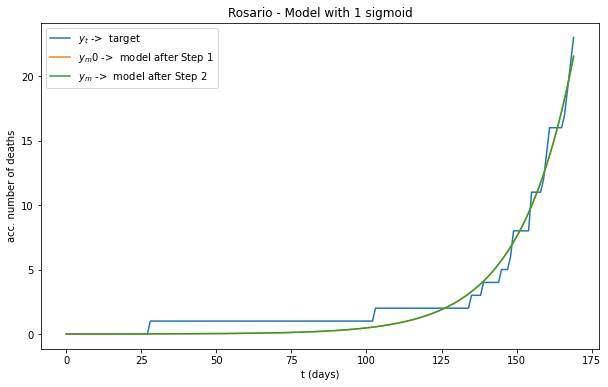

========= Wave nr 2 =========
From 0 to  391
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 5511.130750101192
     jac: array([ 0.        , -0.00018311, -0.00024414,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 107
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([1.31994967e+03, 2.50741610e+02, 3.64466478e+01, 1.00000000e+00])
Step 2
     fun: 3420.8233378768823
     jac: array([0.00000000e+00, 3.05175781e-04, 7.01904297e-04, 2.27193478e+03])
 message: 'Optimization terminated successfully'
    nfev: 67
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([1.40530202e+03, 2.34303243e+02, 5.63120516e+01, 1.00000000e-01])


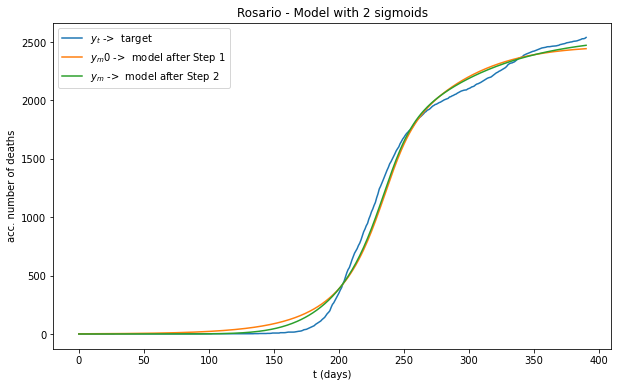

========= Wave nr 3 =========
From 0 to  671
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 1997.7469185242362
     jac: array([-0.0005188 ,  0.00721741,  0.00115967,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 82
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([1.78544963e+03, 4.60318981e+02, 2.23097617e+01, 1.00000000e+00])
Step 2
     fun: 1962.1791107549086
     jac: array([ 0.0007019 , -0.00419617,  0.00172424,  0.09373474])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([1.79119936e+03, 4.57447634e+02, 2.45811254e+01, 7.42009727e-01])


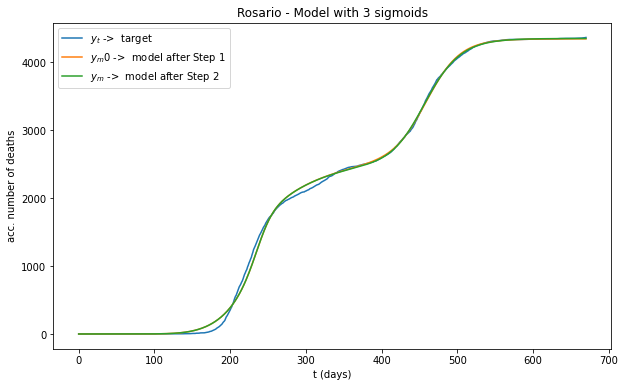

========= Wave nr 4 =========
From 0 to  774
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 1702.714711155921
     jac: array([ 9.15527344e-05, -7.32421875e-04,  3.05175781e-04,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 86
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([306.37456565, 692.56312392,   7.72932914,   1.        ])
Step 2


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 1700.8436402678444
     jac: array([ 0.00010681, -0.00010681,  0.        ,  0.00120544])
 message: 'Optimization terminated successfully'
    nfev: 63
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([3.08570853e+02, 6.89880547e+02, 9.76870816e+00, 3.80058690e-01])


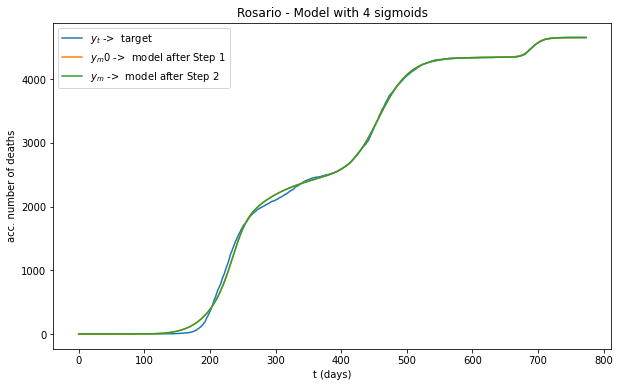

In [11]:
n_weeks_pred = 2
n_sig = 1
sig_params = []
for i in range(len(x_nw) + 1):
    if(i == len(x_nw)):
        n_days = len(acc_data) - 7*n_weeks_pred
    else:
        n_days = x_nw[i]
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    # Initial values
    if(i == 0):
        y_t = acc_data[:n_days]
        A0 = 2*max(y_t)
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 100
        A0 *= 0.05
        #A0 *= 1.2
    # else:
    #     [A0, tp0, delta0, nu0] = sig_params[len(sig_params) - 1]
    #     tp0 = tp0 + 100
    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    y_t = acc_data[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"
    plt.figure(figsize=(10,6))
    plt.title(f'{city_name} - Model with {n_sig} sigmoid{s}')
    plt.plot(y_t, label='$y_t$ ->  target')
    plt.plot(y_m0, label='$y_m0$ ->  model after Step 1')
    plt.plot(y_m, label='$y_m$ ->  model after Step 2')
    plt.xlabel('t (days)')
    plt.ylabel('acc. number of deaths')
    plt.legend()
    plt.savefig(f'output/{i:003}', facecolor='white', dpi=100)
    plt.show()
    
    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    print(f'===================================')    

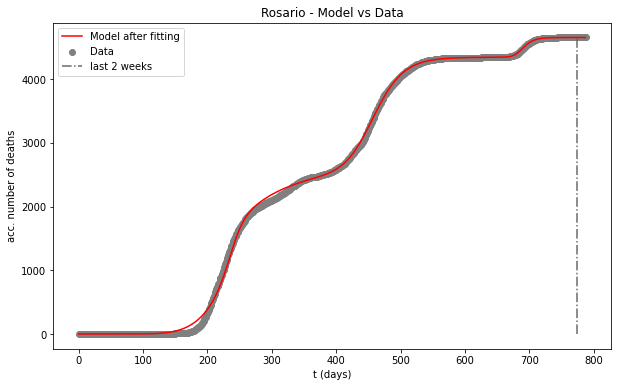

In [12]:
n_sig = 4
plt.figure(figsize=(10,6))
#plt.xlim(len(acc_data) - 7*n_weeks_pred, len(acc_data))
plt.title(f'{city_name} - Model vs Data')
plt.scatter(t, acc_data, label='Data', c='gray')
plt.vlines(len(acc_data) - 7*n_weeks_pred, 0, max(acc_data), colors='dimgray', linestyles='dashdot', zorder=1, label=f"last {n_weeks_pred} weeks")
n_days = len(acc_data)
plt.plot(model(t, A, tp, delta, nu), label='Model after fitting', c='r')
plt.xlabel('t (days)')
plt.ylabel('acc. number of deaths')
plt.legend()
plt.savefig(f'output/005', facecolor='white', dpi=100)
plt.show()
n_days = len(acc_data) -7*n_weeks_pred

In [13]:
#n_days = len(acc_data) - 7*n_weeks_pred
n_days = len(acc_data)

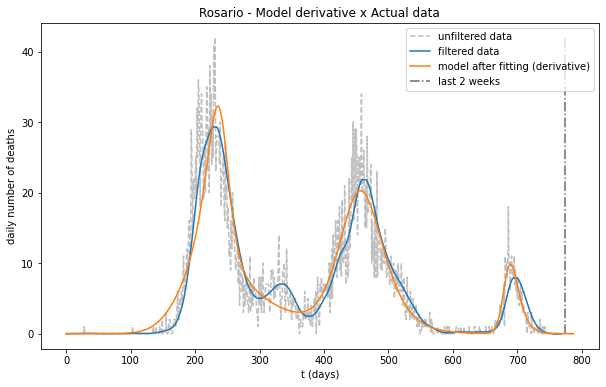

In [14]:
y_m = model(t, A, tp, delta, nu)

model_der = forward_euler(t[:n_days], 1, y_m[:n_days], 0)
daily_data = forward_euler(t[:n_days], 1, acc_data[:n_days], 0)

plt.figure(figsize=(10, 6))
plt.title(f'{city_name} - Model derivative x Actual data')
plt.plot(daily_data, label="unfiltered data", c='silver', linestyle='dashed')
plt.plot(filter_data(daily_data), label="filtered data")
plt.plot(model_der, label='model after fitting (derivative)')
plt.vlines(len(acc_data) - 7*n_weeks_pred, 0, max(daily_data), colors='dimgray', linestyles='dashdot', zorder=1, label=f"last {n_weeks_pred} weeks")
plt.xlabel('t (days)')
plt.ylabel('daily number of deaths')
plt.savefig(f'output/{city_name}_der', facecolor='white', dpi=100)
plt.legend()
plt.show()

#### ===== Mudando apresentação dos resultados ======

In [15]:
x_nw_orig = x_nw
x_nw.append(len(acc_data))
print(x_nw)

[170, 391, 671, 788]


In [16]:
print(x_nw)

[170, 391, 671, 788]


========= Wave nr 1 =========
From 0 to  156
Step 1
     fun: 0.5155414360568912
     jac: array([ 1.78813934e-06, -1.33313239e-04,  7.71924853e-04,  0.00000000e+00])
 message: 'Iteration limit reached'
    nfev: 516
     nit: 100
    njev: 100
  status: 9
 success: False
       x: array([1.14134269e+03, 2.89642665e+02, 2.68984060e+01, 1.00000000e+00])
Step 2
     fun: 0.5155412296226239
     jac: array([ 1.78813934e-06, -1.33313239e-04,  7.71924853e-04,  9.58141685e-03])
 message: 'Optimization terminated successfully'
    nfev: 9
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([1.14134269e+03, 2.89642666e+02, 2.68984025e+01, 9.99957181e-01])


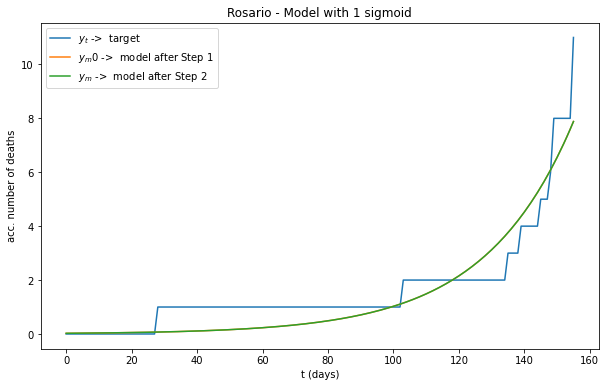

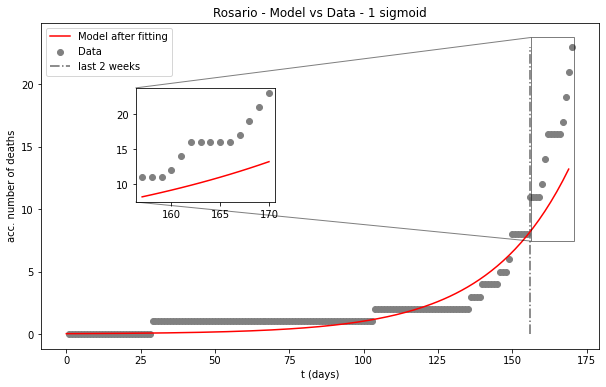

========= Wave nr 2 =========
From 0 to  377
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 2145.181440643815
     jac: array([0.        , 0.00012207, 0.00033569, 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 327
     nit: 60
    njev: 59
  status: 0
 success: True
       x: array([1.43340589e+03, 2.16480796e+02, 1.08542574e+01, 1.00000000e+00])
Step 2
     fun: 2008.9515887793234
     jac: array([-0.00080872,  0.00570679, -0.00878906, -0.04562378])
 message: 'Optimization terminated successfully'
    nfev: 63
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([1430.51253824,  220.32085216,    8.50385225,    1.82109521])


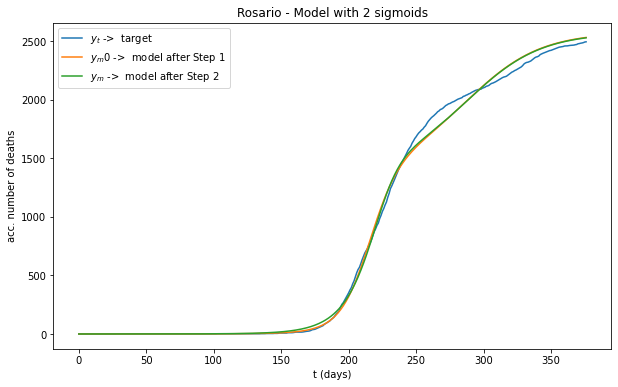

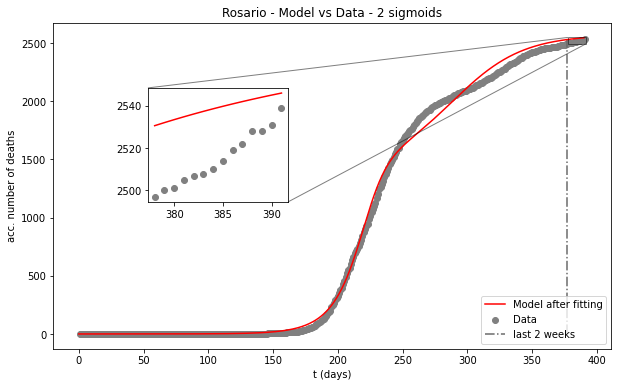

========= Wave nr 3 =========
From 0 to  657
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 1590.7380408523786
     jac: array([-1.52587891e-05, -1.52587891e-04, -9.15527344e-05,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 84
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([1.75781860e+03, 4.62194457e+02, 2.04616708e+01, 1.00000000e+00])
Step 2
     fun: 1245.4189573667597
     jac: array([ 6.10351562e-05, -4.40979004e-03,  3.37219238e-03,  1.28753662e-01])
 message: 'Optimization terminated successfully'
    nfev: 64
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([1.77810219e+03, 4.53533802e+02, 2.75738659e+01, 2.80818974e-01])


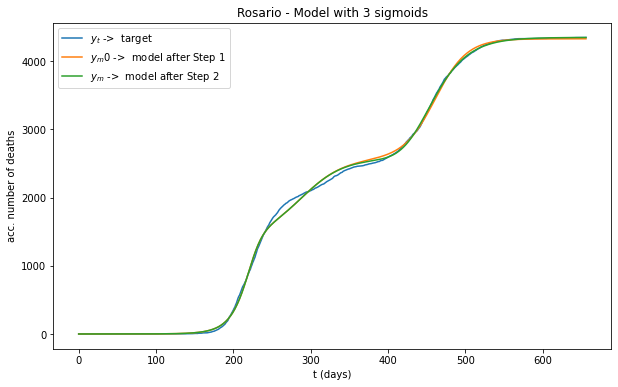

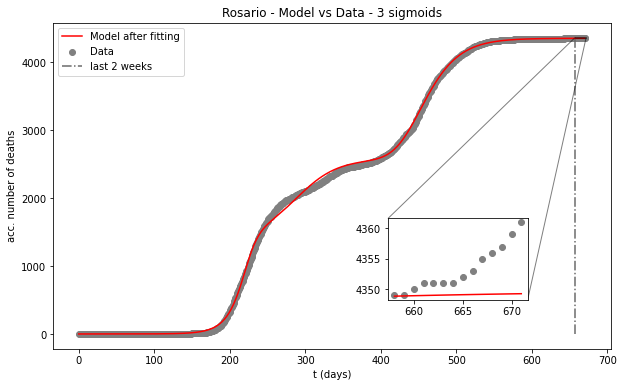

========= Wave nr 4 =========
From 0 to  774
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 1060.7454760039043
     jac: array([-6.10351562e-05,  1.67846680e-04,  7.62939453e-05,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 82
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([303.17773038, 692.76151409,   7.55361861,   1.        ])
Step 2


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 1057.850158687168
     jac: array([ 0.00050354, -0.00061035, -0.00018311,  0.0045166 ])
 message: 'Optimization terminated successfully'
    nfev: 64
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([3.05914225e+02, 6.89457959e+02, 1.00876897e+01, 2.54944252e-01])


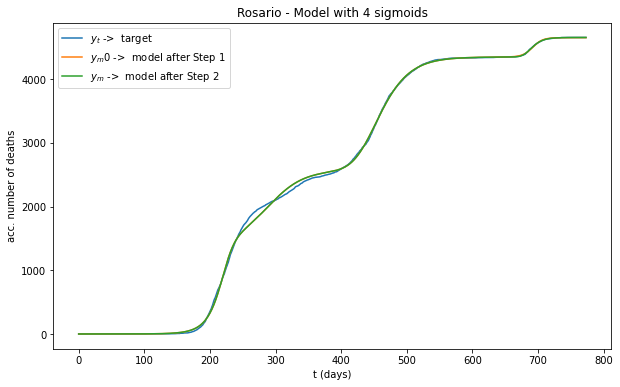

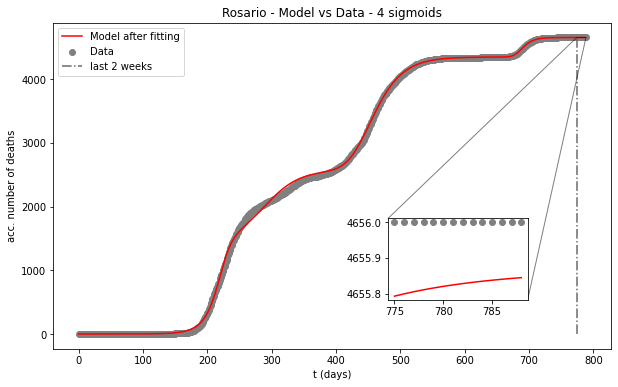

In [18]:
n_weeks_pred = 2
n_sig = 1
sig_params = []
for i in range(len(x_nw)):
    n_days = x_nw[i]- 7*n_weeks_pred
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    # Initial values
    if(i == 0):
        y_t = acc_data[:n_days]
        A0 = 2*max(y_t)
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 100
        A0 *= 0.05
        #A0 *= 1.2
    # else:
    #     [A0, tp0, delta0, nu0] = sig_params[len(sig_params) - 1]
    #     tp0 = tp0 + 100
    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    y_t = acc_data[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"
    plt.figure(figsize=(10,6))
    plt.title(f'{city_name} - Model with {n_sig} sigmoid{s}')
    plt.plot(y_t, label='$y_t$ ->  target')
    plt.plot(y_m0, label='$y_m0$ ->  model after Step 1')
    plt.plot(y_m, label='$y_m$ ->  model after Step 2')
    plt.xlabel('t (days)')
    plt.ylabel('acc. number of deaths')
    plt.legend()
    plt.savefig(f'output/{i:003}', facecolor='white', dpi=100)
    plt.show()

    # Model vs Data
    #plt.figure(figsize=(10,6))
    fig, ax = plt.subplots(figsize=[10,6])
    #plt.xlim(x_nw[i] - 7*(n_weeks_pred + 1), x_nw[i])
    ax.set_title(f'{city_name} - Model vs Data - {n_sig} sigmoid{s}')
    n_days = x_nw[i]
    ax.scatter(t[:n_days], acc_data[:n_days], label='Data', c='gray')
    ax.vlines(n_days - 7*n_weeks_pred, 0, max(acc_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"last {n_weeks_pred} weeks")
    y_model = model(t[:n_days], A, tp, delta, nu)
    ax.plot(y_model, label='Model after fitting', c='r')
    ax.set_xlabel('t (days)')
    ax.set_ylabel('acc. number of deaths')
    ax.legend()
    X_detail = t[x_nw[i]- 7*n_weeks_pred: x_nw[i]]
    Y_detail = y_model[x_nw[i]- 7*n_weeks_pred: x_nw[i]]
    # detail prediction with zoom
    if(n_sig < 3):
        sub_axes = ax.inset_axes([.17, .45, .25, .35]) 
    else:
        sub_axes = ax.inset_axes([.6, .15, .25, .25]) 
    sub_axes.scatter(t[n_days - 7*n_weeks_pred:n_days], acc_data[n_days - 7*n_weeks_pred:n_days], label='Data', c='gray')
    sub_axes.plot(X_detail, Y_detail, c = 'r') 
    #sub_axes.set_xticks(X_detail[0::3])
    ax.indicate_inset_zoom(sub_axes, edgecolor="black")

    
    plt.savefig(f'output/ro_{n_sig}_sig', facecolor='white', dpi=100)
    plt.show()
    
    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    print(f'===================================')    

#### ===== Rascunho (testes para melhor entendimento) =====

In [49]:
X_detail[0::3]

array([806., 809., 812., 815., 818.])

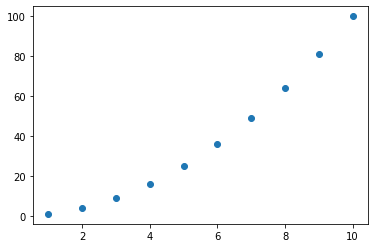

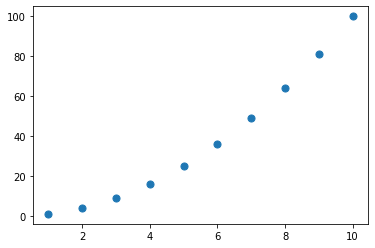

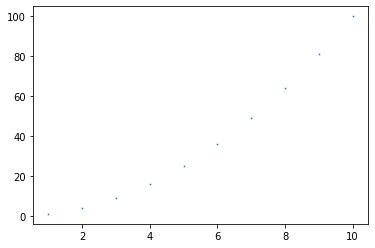

In [31]:
a = np.linspace(1, 10, 10)
plt.scatter(a, a**2)
plt.show()
plt.scatter(a, a**2, s=50)
plt.show()
plt.scatter(a, a**2, s=0.5)
plt.show()

In [ ]:
[(5-i)*0.05 for i in range(0,5)]

In [ ]:
n_sig = 1
n_days = 90
# Initialize model parameters
A = 1500
tp = 20
delta = 3.1
nu = 2.2

y_t = acc_data[:n_days]
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('One Sigmoid (Single Wave)')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m, label='$y_m$ ->  model')
plt.plot(y_t - y_m, label='$y_t - y_m$')
plt.plot(abs(y_t - y_m), label='|$y_t - y_m$|')
plt.xlabel('t (days)')
plt.ylabel('acc. number of deaths')
plt.legend()
plt.show()
plt.title('Squared Error')
plt.plot((y_t - y_m)**2, label='$(y_t - y_m)^2$')
plt.legend()
plt.show()
plt.title('Time Squared Error')
plt.plot(t[:n_days]*(y_t - y_m)**2, label='$t(y_t - y_m)^2$')
plt.xlabel('t (days)')
plt.ylabel('acc. number of deaths')
plt.legend()
plt.show()


In [ ]:
# Fazendo testes com múltiplas ondas
# Modelo envolvendo soma de sigmoides assimétricas 
n_sig = 4
x = np.random.rand(4*n_sig)
x

In [ ]:
# Antigo... ignorar
n_sig = 4
# inicialização aleatória
x = np.random.rand(4*n_sig)
sigsum = np.zeros(n_days)
for i in range(n_sig):
    A = 1e2*x[i + 0]
    tp = 8*(i+1)
    delta = 2*x[i + 2]
    nu = 1
    sigsum += f_t(t[:n_days], A, tp, delta, nu)
plt.plot(sigsum)
plt.show()